# Fluxonium CZ gate tutorial

B. McDonough

This notebook provides a tutorial for using scQubits to simulate the procedure for effecting a CZ-gate on a coupled pair of fluxonium qubits described by Nesterov et al. in [Microwave-Activated Controlled-Z Gate for Fixed-Frequency Fluxonium Qubits.](https://arxiv.org/abs/1802.03095)

Capacitive coupling of two fluxonium qubits $A$ and $B$ results in the addition of the term $g \hat n_A \hat n_B$ to the Hamiltonian. This coupling shifts the energy levels so that the $\omega_{01\to 02}$ transition frequency is detuned from the $\omega_{11 \to 12}$ transition frequency. This allows the $\ket{11} \to \ket{12}$ transition to be driven without causing leakage from other states in the computational space. Following Nesterov et al., we consider a drive on only qubit $B$, which is expressed as the term $f(t)\cos(\omega_d t)\hat n_B$ added to the Hamiltonian.

Driving the $\ket{11}\to\ket{12}$ transition for a full period causes the $\ket{11}$ state to aquire a phase of $e^{i\pi}=-1$, without affecting the other states in the computational subspace. This results in the application of $CZ = \operatorname{diag}(1,1,1,-1)$ up to single-qubit $Z$ gates.

The Hamiltonian of the two coupled fluxonia and the drive is
$$
H = 4E_{CA}\hat n_A - E_{JA}\cos(\hat \phi_A-\pi) + \frac{1}{2} E_{LA}\hat \phi_A^2
+ g\hat n_A\hat n_B + 4E_{CB}\hat n_B - E_{JB}\cos(\hat \phi_B-\pi) + \frac{1}{2}E_{LB}\hat \phi_B^2 + f(t)\cos(w_dt)\hat n_B
$$

In [1]:
import scqubits as scq
import qutip as qt
import numpy as np
from matplotlib import pyplot as plt
from qutip.qip.operations import rz, cz_gate
import cmath

# experimental values borrowed from
# [https://arxiv.org/abs/1802.03095]
qbta = scq.Fluxonium(
    EC=1.5,
    EJ=5.5,
    EL=1.0,
    flux=0.5,  # flux frustration point
    cutoff=110,
    truncated_dim=10,
)

qbtb = scq.Fluxonium(EC=1.2, EJ=5.7, EL=1.0, flux=0.5, cutoff=110, truncated_dim=10)

hilbertspace = scq.HilbertSpace([qbta, qbtb])

hilbertspace.add_interaction(
    g_strength=0.15,
    op1=qbta.n_operator,
    op2=qbtb.n_operator,
)

hilbertspace.generate_lookup()

## Drive simulation functions

In [4]:
def basis_change(
    operator: np.ndarray,
    subsystem: scq.core.qubit_base.QuantumSystem,
    hilbertspace: scq.HilbertSpace,
) -> qt.Qobj:
    """This method can be used to express a subsystem operator in the dressed energy eigenbasis
    of the full hilbertspace, expecially useful for simulations in QuTiP.

    Args:
        operator (Qobj): A subsystem operator with dimension cutoff x cutoff
        subsystem (Qubit or Resonator): The subsystem acted on by the operator
        hilbertspace (HilbertSpace): The Hilbert space representing the composite system

    Returns:
        (Qobj): An operator with the same dimension as the HilbertSpace
    """

    # Get bare eigenvectors of subsystem stored in hilbertspace
    (bare_evecs,) = hilbertspace.bare_eigenstates(subsystem)
    # Express operator in bare eigenbasis and tensor with appropriate identities
    op_id_wrap = scq.identity_wrap(
        operator, subsystem, hilbertspace.subsys_list, evecs=bare_evecs
    )
    # Get full dressed eigenbasis
    (evecs,) = hilbertspace["evecs"]
    return op_id_wrap.transform(evecs)

# get the transition frequency between two states specified by dressed indices
def transition_frequency(s0: int, s1: int) -> float:
    return (
        (
            hilbertspace.energy_by_dressed_index(s1)
            - hilbertspace.energy_by_dressed_index(s0)
        )
        * 2
        * np.pi
    )

## Truncation
As discussed in `FluxoniumResetTutorial.ipynb`, the operators in the dressed eigenbasis can be trunctated after digonalization.

In [5]:
# The matrix representations can be truncated further for the simulation
total_truncation = 20

# truncate operators to desdired dimension
def truncate(operator: qt.Qobj, dimension: int) -> qt.Qobj:
    return qt.Qobj(operator[:dimension, :dimension])

## States and operators 

In [8]:
# charge operator for qubit b
n_b = basis_change(qbtb.n_operator(), qbta, hilbertspace)
n_b = truncate(n_b, total_truncation)

In [9]:
# convert the product states to the closes eigenstates of the dressed system
product_states = [(0, 0), (0, 1), (1, 0), (1, 1), (1, 2)]
idxs = [hilbertspace.dressed_index((s1, s2))[0] for (s1, s2) in product_states]
states = [qt.basis(total_truncation, idx) for idx in idxs]

# The computational subspace is spanned by the first 4 states
computational_subspace = states[:4]

## Units
scQubits uses units in which $h=1$ to transform into units where $\hbar = 1$ so that time is in units of nanoseconds, the energies, and likewise the drive operators, need to be multiplied by $2\pi$.

In [12]:
omega_1112 = transition_frequency(idxs[3], idxs[4])

# Gaussian pulse parameters optimized by hand
A = 0.02
tg = 100


def drive_coeff(t: float, args: dict) -> float:
    return A * np.exp(-8 * t * (t - tg) / tg**2) * np.cos(omega_1112 * t)


# Hamiltonian in dressed eigenbasis
(evals,) = hilbertspace["evals"]
# The factor of 2pi converts the energy to GHz so that the time is in units of ns
diag_dressed_hamiltonian = (
    2 * np.pi * qt.Qobj(np.diag(evals), dims=[hilbertspace.subsystem_dims] * 2)
)
diag_dressed_hamiltonian_trunc = truncate(diag_dressed_hamiltonian, total_truncation)

# time-dependent drive Hamiltonian
H_qbt_drive = [
    diag_dressed_hamiltonian_trunc,
    [2 * np.pi * n_b, drive_coeff],  # driving through the resonator
]

## Drive Visualization

Text(0.5, 0, 't (ns)')

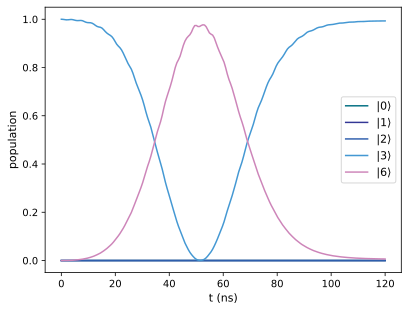

In [13]:
tlist = np.linspace(0, 120, 200)  # total time

# This simulation is just for viewing the affect of the pulse
result = qt.sesolve(
    H_qbt_drive, qt.basis(20, 3), tlist, e_ops=[state * state.dag() for state in states]
)

for idx, res in zip(idxs, result.expect):
    plt.plot(tlist, res, label=r"$|%u\rangle$" % (idx))

plt.legend()
plt.ylabel("population")
plt.xlabel("t (ns)")

## Propagator calculation

In [14]:
prop = qt.propagator(H_qbt_drive, tlist)[
    -1
]  # get the propagator at the final time step
# truncate the propagator to the computational subspace
Uc = qt.Qobj(
    [
        [prop.matrix_element(s1, s2) for s1 in computational_subspace]
        for s2 in computational_subspace
    ]
)

In [24]:
# Factor global phase so that upper-left corner of matrix is real
def remove_global_phase(op):
    return op * np.exp(-1j * cmath.phase(op[0, 0]))


# The process for obtaining the Z rotations is taken from page 3 of Nesterov et al., at the
# bottom of the paragraph beginning, "To model gate operation..."
def dphi(state):
    return -np.angle(prop.matrix_element(state, state)) + np.angle(
        prop.matrix_element(states[0], states[0])
    )

In [23]:
# product of single-qubit Z-gates
Uz = remove_global_phase(qt.tensor(rz(dphi(states[2])), rz(dphi(states[1]))))
Uc_reshaped = qt.Qobj(Uc.data, dims=[[2, 2], [2, 2]])
Ucprime = remove_global_phase(Uz * Uc_reshaped)
Ucprime  # result should be close to diag(1,1,1,-1)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 9.99998953e-01+0.00000000e+00j  6.28560639e-07-5.25993070e-07j
   9.86707171e-05-6.05237478e-05j -2.00598977e-07-1.27343041e-10j]
 [-6.27489356e-07-5.26690523e-07j  9.98501126e-01+0.00000000e+00j
  -1.45812200e-06-1.58735721e-06j -1.95632538e-05-5.03666197e-05j]
 [-9.87635546e-05-6.06574834e-05j  5.71321164e-07-5.08551792e-07j
   9.99642996e-01+0.00000000e+00j -4.28553018e-07-2.33185618e-07j]
 [-3.73676436e-08+4.06599423e-08j -1.41434273e-05+5.24115016e-05j
  -4.00784710e-07+2.76298054e-07j -9.91317214e-01+1.01837280e-01j]]

In [22]:
#fidelity measure given on page 3 of Nesterov et al.
((Ucprime.dag() * Ucprime).tr() + np.abs((Ucprime.dag() * cz_gate()).tr()) ** 2) / 20

0.9957766719663617